In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from tqdm import tqdm
from PIL import Image
import time 
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
from torchmetrics import Accuracy, Precision, Recall, F1Score

In [2]:

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))

        self.images = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                self.images.append(image_path)
                self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
def create_data_loaders(dataset_path, train_size=0.8, batch_size=32, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
    ])

    dataset = CustomDataset(dataset_path, transform=transform)

    # Define sizes for train, validation, and test sets
    train_size = int(train_size * len(dataset))
    val_size = (len(dataset) - train_size) // 2
    test_size = len(dataset) - train_size - val_size

    # Split dataset into train, validation, and test sets
    train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoader instances for training, validation, and testing
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [5]:
# Define the dataset path
dataset_path = 'C:/Users/hamdi/Desktop/pfa/Plant_leaf_diseases_dataset_with_augmentation/Plant_leave_diseases_dataset_with_augmentation'

# Define batch size for DataLoader
batch_size = 32

# Create CustomDataLoader instances for training, validation, and testing
train_loader, val_loader, test_loader = create_data_loaders(dataset_path, batch_size=batch_size)

# Check the lengths of the loaders
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 1538
Number of batches in val_loader: 193
Number of batches in test_loader: 193


In [9]:
for image, label in test_loader:
    
    min_val = torch.min(image)
    mean_val = torch.mean(image)
    max_val = torch.max(image)
    
    print(min_val.item(), mean_val.item(), max_val.item())
    break

0.0 0.48252156376838684 1.0


Our Model

In [10]:
class MultiClassCNN(nn.Module):
    def __init__(self):
        super(MultiClassCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc_block = nn.Sequential(
            nn.Linear(32 * 62 * 62, 256),  # Calculated based on the output size after convolutions
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 39)  # 39 classes
        ) 

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.fc_block(x)
        return x


Convolution Layers (nn.Conv2d):

First Layer: Converts the 3-channel (RGB images) input into 16 feature maps. The kernel_size is 3 and stride is 1.
Second Layer: Takes the 16 feature maps from the first convolution layer and transforms them into 32 feature maps.

Activation Function (nn.ReLU):

ReLU (Rectified Linear Unit) is used as the activation function after each convolution layer to introduce non-linearity, enabling the model to capture complex relationships in the data.

Pooling Layers (nn.MaxPool2d):

Reduces the spatial dimensions (height and width) of the input, which decreases the number of parameters and computation required in the network, while also allowing the network to better generalize by extracting more robust features.

Flatten Layer (nn.Flatten):

Flattens the feature maps into a single vector to allow processing by fully connected (dense) layers.

Fully Connected Layers (nn.Linear):

First Dense Layer: Transforms the flattened features into a vector of size 256.
Second Dense Layer: Further reduces the features to 128.
Output Layer: The final dense layer transforms the feature vector into 39 scores, one for each class.

forward Function:

Data Flow (forward method): Defines how data moves through the network. Input data first passes through the conv_block, gets flattened by flatten, and finally goes through fc_block to produce the network’s outputs. This method is crucial as it specifies the forward propagation path during the training and evaluation of the model.


In summary, MultiClassCNN is a typical CNN architecture with convolutional layers for feature extraction and fully connected layers for classification. This allows the model to process input images, learn important spatial features, and classify these images into one of 39 classes.

In [12]:

model = MultiClassCNN()

# Calcul du nombre total de paramètres
total_params = sum(p.numel() for p in model.parameters())
print(f"Nombre total de paramètres dans le modèle : {total_params}")

Nombre total de paramètres dans le modèle : 31533319


Epoch 1: 100%|██████████| 1538/1538 [37:26<00:00,  1.46s/it]   


Epoch 1, Loss: 1.1122
Accuracy: 0.6069, Precision: 0.6344, Recall: 0.6069, F1 Score: 0.6177


Validation: 100%|██████████| 193/193 [01:16<00:00,  2.51it/s]


Validation Loss: 0.6026, Validation Accuracy: 0.7709
Time elapsed for epoch 1: 2323.94 seconds


Epoch 2: 100%|██████████| 1538/1538 [2:23:30<00:00,  5.60s/it]     


Epoch 2, Loss: 0.4554
Accuracy: 0.7153, Precision: 0.7327, Recall: 0.7153, F1 Score: 0.7228


Validation: 100%|██████████| 193/193 [00:44<00:00,  4.31it/s]


Validation Loss: 0.5872, Validation Accuracy: 0.7798
Time elapsed for epoch 2: 8655.41 seconds


Epoch 3: 100%|██████████| 1538/1538 [1:14:41<00:00,  2.91s/it]     


Epoch 3, Loss: 0.2596
Accuracy: 0.7760, Precision: 0.7897, Recall: 0.7760, F1 Score: 0.7822


Validation: 100%|██████████| 193/193 [01:14<00:00,  2.58it/s]


Validation Loss: 0.5514, Validation Accuracy: 0.7871
Time elapsed for epoch 3: 4556.25 seconds


Epoch 4: 100%|██████████| 1538/1538 [21:20<00:00,  1.20it/s]


Epoch 4, Loss: 0.1706
Accuracy: 0.8149, Precision: 0.8263, Recall: 0.8149, F1 Score: 0.8202


Validation: 100%|██████████| 193/193 [00:43<00:00,  4.41it/s]


Validation Loss: 0.4726, Validation Accuracy: 0.8002
Time elapsed for epoch 4: 1324.60 seconds


Epoch 5: 100%|██████████| 1538/1538 [17:43<00:00,  1.45it/s]


Epoch 5, Loss: 0.1315
Accuracy: 0.8417, Precision: 0.8513, Recall: 0.8417, F1 Score: 0.8462


Validation: 100%|██████████| 193/193 [00:45<00:00,  4.23it/s]


Validation Loss: 0.4937, Validation Accuracy: 0.8115
Time elapsed for epoch 5: 1109.06 seconds


Epoch 6: 100%|██████████| 1538/1538 [17:15<00:00,  1.49it/s]


Epoch 6, Loss: 0.0980
Accuracy: 0.8618, Precision: 0.8702, Recall: 0.8618, F1 Score: 0.8658


Validation: 100%|██████████| 193/193 [00:45<00:00,  4.23it/s]


Validation Loss: 0.5421, Validation Accuracy: 0.8188
Time elapsed for epoch 6: 1081.00 seconds


Epoch 7: 100%|██████████| 1538/1538 [17:41<00:00,  1.45it/s]


Epoch 7, Loss: 0.0949
Accuracy: 0.8764, Precision: 0.8839, Recall: 0.8764, F1 Score: 0.8800


Validation: 100%|██████████| 193/193 [00:44<00:00,  4.37it/s]


Validation Loss: 0.5740, Validation Accuracy: 0.8223
Time elapsed for epoch 7: 1105.81 seconds


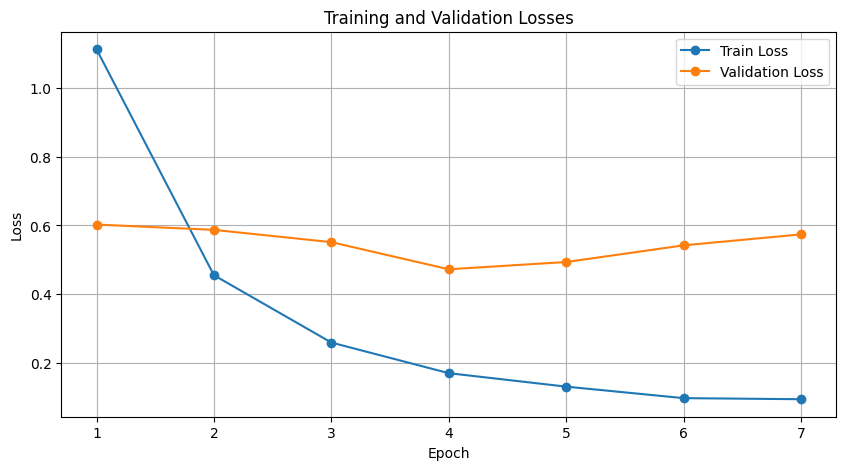

In [13]:
# Initialization of the model
model = MultiClassCNN()

# Definition of loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Initialization of metrics
accuracy = Accuracy(task='multiclass', num_classes=39, average='macro')
precision = Precision(task='multiclass', num_classes=39, average='macro')
recall = Recall(task='multiclass', num_classes=39, average='macro')
f1 = F1Score(task='multiclass',num_classes=39, average='macro')
val_accuracy = Accuracy(task='multiclass', num_classes=39, average='macro')  # Initialize validation accuracy outside the loop
epoch_losses= []
val_losses=[]
# Training loop
for epoch in range(7):  # Number of epochs
    start_time = time.time()  # Start time
    
    running_loss = 0.0
    model.train()  # Set model to training mode
    
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Update metrics
            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)
            f1.update(outputs, labels)

    
    # Calculate metrics after each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)  # Store epoch loss
    acc = accuracy.compute()
    prec = precision.compute()
    rec = recall.compute()
    f1_score = f1.compute()
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1_score:.4f}")
    
    # Validation loop
    val_loss = 0.0
    model.eval()  # Set model to evaluation mode
    
    for val_images, val_labels in tqdm(val_loader, desc="Validation"):
        with torch.no_grad():
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()
            val_accuracy.update(val_outputs, val_labels)
    val_acc = val_accuracy.compute()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)  # Store validation loss
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    # Elapsed time
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Time elapsed for epoch {epoch+1}: {epoch_time:.2f} seconds")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
model = MultiClassCNN()
# Initialize metrics
accuracy = Accuracy(task='multiclass',num_classes=39, average='macro')
precision = Precision(task='multiclass',num_classes=39, average=None)
recall = Recall(task='multiclass',num_classes=39, average=None)

# Put the model in evaluation mode
model.eval()

# Iterate over the test data
for images, labels in test_loader:
    # Forward pass to get the predicted labels
    with torch.no_grad():
        outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)
    
    # Update metrics
    accuracy.update(predicted, labels)
    precision.update(predicted, labels)
    recall.update(predicted, labels)

# Compute final values
accuracy = accuracy.compute()
precision = precision.compute()
recall = recall.compute()

# Print accuracy, precision, and recall
print("Accuracy:", accuracy)
print("Per-class Precision:", precision)
print("Per-class Recall:", recall)

Accuracy: tensor(0.0233)
Per-class Precision: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0108, 0.0000, 0.0000, 0.0197,
        0.0160, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
Per-class Recall: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0777, 0.0000, 0.0000, 0.0688,
        0.7629, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
